<a href="https://colab.research.google.com/github/arnavdodiedo/RL-Algorithms/blob/main/DQN_MountainCar_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as f
import matplotlib.pyplot as plt
import random
import copy
from collections import deque
import gym
from tqdm import tqdm

!apt update && apt install xvfb
!pip install gym-notebook-wrapper

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [450 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,414 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubunt

In [ ]:
class DQNagent():
    def __init__(self, seed, layer_sizes, lr, sync_freq, exp_replay_size):
        torch.manual_seed(seed)
        self.qnet = self.build_network(layer_sizes)
        self.targetnet = copy.deepcopy(self.qnet)
        self.qnet.cuda()
        self.targetnet.cuda()
        self.mseloss = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.qnet.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=0.9)
        # self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, patience=10, factor=0.9)

        self.sync_freq = sync_freq
        self.sync_counter = 0
        self.gamma = torch.tensor(0.95).float().cuda()
        self.replay = deque(maxlen = exp_replay_size)
    
    def build_network(self, layer_sizes):
        layers = []
        for i in range(len(layer_sizes)-1):
            lin = nn.Linear(layer_sizes[i], layer_sizes[i+1])
            act = nn.Tanh() if i < len(layer_sizes)-2 else nn.Identity()
            layers += (lin, act)
        return nn.Sequential(*layers)
    
    def load_model(self, path):
        self.qnet.load_state_dict(torch.load(path))

    def save_model(self, path):
        torch.save(self.qnet.state_dict(), path)
    
    def get_action(self, state, action_space_len, epsilon):
        with torch.no_grad():
            Q = self.qnet(torch.from_numpy(state).float().cuda())
        Q, A = torch.max(Q, axis=0)
        A = A if torch.rand(1,).item() > epsilon else torch.randint(0, action_space_len, (1,))
        return A
    
    def get_q_next(self, state):
        with torch.no_grad():
            Q = self.targetnet(state.cuda())
        q, _ = torch.max(Q, axis=1)
        return q

    def collect_experience(self, exp):
        self.replay.append(exp)
    
    def sample_from_exp(self, size):
        if(len(self.replay)<size): size = len(self.replay)

        sample = random.sample(self.replay, size)

        s = torch.tensor([exp[0] for exp in sample]).float()
        a = torch.tensor([exp[1] for exp in sample]).float()
        rn = torch.tensor([exp[2] for exp in sample]).float()
        sn = torch.tensor([exp[3] for exp in sample]).float()
        d = torch.tensor([int(exp[4]==False) for exp in sample]).float()

        return s, a, rn, sn, d

    def train(self, size):
        s, a, rn, sn, done = self.sample_from_exp(size)

        if(self.sync_counter>self.sync_freq):
            self.sync_counter = 0
            self.targetnet.load_state_dict(self.qnet.state_dict())

        qp = self.qnet(s.cuda())
        pred_r, _ = torch.max(qp, axis=1)
        q_next = self.get_q_next(sn.cuda())
        # q_next, _ = torch.max(self.qnet(sn.cuda()), axis=1)

        target = rn.cuda() + self.gamma * q_next * done.cuda()

        loss = self.mseloss(pred_r, target)
        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        self.optimizer.step()
        # self.scheduler.step(loss)

        self.sync_counter += 1
        return loss.item()

In [ ]:
env = gym.make('MountainCar-v0')
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n

exp_replay_size = 512

agent = DQNagent(seed=1423, layer_sizes=[input_dim, 64, output_dim], lr=1e-5, sync_freq=7, exp_replay_size=exp_replay_size)

agent.qnet.train()
agent.targetnet.train()

loss_list = []
reward_list = []
ep_len_list = []
epsilon_list = []

episode = 5000
epsilon = 0.4

index = 0

for i in range(exp_replay_size):
    obs = env.reset()
    done = False

    while not done:
        A = agent.get_action(obs, output_dim, epsilon=1)
        obs_next, reward, done, _ = env.step(A.item())

        agent.collect_experience([obs, A.item(), reward, obs_next, done])
        obs = obs_next
        index += 1    
    
    if index>exp_replay_size: break

for i in tqdm(range(episode)):
    obs = env.reset()
    done = False
    losses, rewards, ep_len = 0, 0, 0

    while not done:
        ep_len += 1
        A = agent.get_action(obs, output_dim, epsilon)        
        obs_next, rew, done, _ = env.step(A.item())
        agent.collect_experience([obs, A.item(), rew, obs_next, done])

        obs = obs_next

        rewards += rew

        index += 1

        # if index>128:
        #     index = 0
        #     for j in range(4):
    for j in range(8):
        loss = agent.train(64)        
        losses += loss
        
    if obs[0]>=0.5 and epsilon > 0.05:
        epsilon -= (1/5000)
        agent.scheduler.step()
        
    loss_list.append(losses/ep_len)
    reward_list.append(rewards)
    ep_len_list.append(ep_len)
    epsilon_list.append(epsilon)

print("\nSaving trained model")
agent.save_model("mountaincar-v0-dqn.pth")

 72%|███████▏  | 3596/5000 [04:14<01:33, 15.04it/s]

In [ ]:
plt.plot(reward_list)
plt.ylabel("rewards")
plt.show()
plt.plot(epsilon_list)
plt.ylabel("epsilon")
plt.show()
plt.plot(loss_list)
plt.ylabel("loss per epoch for each episode")
plt.show()

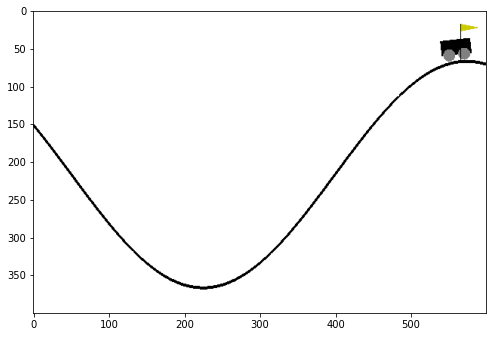

In [ ]:
import matplotlib.animation as animation
import gnwrapper
from PIL import ImageFont, ImageDraw, Image
import numpy as np

agent.qnet.eval()
agent.targetnet.eval()

ACTION_SPACE = [0,1]
env = gnwrapper.LoopAnimation(gym.make('MountainCar-v0'))
# env = gym.make("CartPole-v0")
state = env.reset()

rewards = []
for step in range(500):
    # env.render()
    env.render(mode='rgb_array')
    # A = np.random.randint(0,3)
    # obs_next, rew, done, _ = env.step(A)
    A = agent.get_action(state, output_dim, 0)
    # print(action)
    state, reward, done, _ = env.step(A.item())
    # print(reward)
    rewards.append(reward)

    if done: break

env.display()


In [ ]:
sum(rewards)

-163.0

## Tester module (to be ignored)

In [ ]:
a = torch.rand([2,4])
print(a)
torch.max(a, axis=1)

tensor([[0.3541, 0.1900, 0.1971, 0.7150],
        [0.0637, 0.9444, 0.4648, 0.1539]])


torch.return_types.max(values=tensor([0.7150, 0.9444]), indices=tensor([3, 1]))